<a href="https://colab.research.google.com/github/lamalyon/ProjectMillion/blob/main/FUNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e

## Preliminary

In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 7.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=457821196e6564e61c2ba33129fbc9d0c36466667579a32fcf47d781b43af9e8
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import requests as req
import json
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import time
import datetime
import yfinance as yf


In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
np.set_printoptions(suppress=True)

In [ ]:
def viewAll(df,row=20):
    pd.set_option('display.max_rows', row, 'display.max_columns',None)
    display(df)
    pd.set_option('display.max_rows',20)

## General data processing

In [ ]:
def setPrice(df):
    # set average price from OHLC
    df['Price'] = df[['Open','High','Low','Close']].mean(axis=1).round(2)

def splitDateTime(df):
    # split datetime data into date and time
    # still keep the datetime for sorting
    df['D'] = pd.to_datetime(df['Datetime']).dt.date
    df['T'] = pd.to_datetime(df['Datetime']).dt.time

def formatData(data):
    df = data.copy()
    df.reset_index(inplace=True)
    setPrice(df)
    splitDateTime(df)
    df.sort_values('Datetime',inplace=True,ignore_index=True)
    return round(df[['Datetime','Open','High','Low','Close','Price','Volume','D','T']],2)

all stock data either downloaded throug YF or AV need to be passed through function **formatData** so it can be used further down  
the common stock table should have the format as below

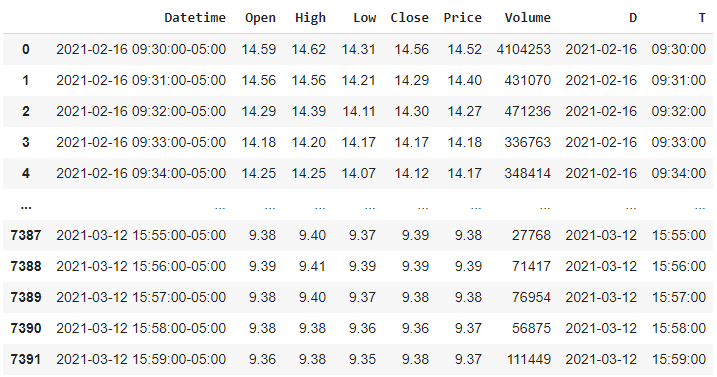

## Get data from Yahoo Finance

In [ ]:
def timeByWeek(weeks=4):
    # create list of 4 pairs start/end date
    # yahoo only provide 4 weeks back date on 1 minute data
    end = datetime.date.today()- datetime.timedelta(1)
    #weeks = 4
    l = []
    for i in range(weeks):
        d = {}
        start = end - datetime.timedelta(7)
        d['start'] = start
        d['end'] = end
        l.append(d)
        end = start
    return l

def YFData(ticker,interval='1m',numWeek=4):
    # get one month of 1 minute data
    l = []
    for i in timeByWeek(numWeek):
        print(i)
        l.append(yf.Ticker(ticker).history(interval=interval,start=i['start'],end=i['end']))
    df = pd.concat(l)
    return df



In [ ]:
# test code
#data = YFMonthMinuteData('BNGO')
#df = formatData(data)

## Get data from Alpha Vantage

In [ ]:
AVkey = 'T8BGSSZLI8NC37WC'

def AV_intraday(symbol, interval='1min', period='year1month1'):
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={symbol}&interval={interval}&slice={period}&adjusted=false&apikey={key}'
    query = url.format(symbol = symbol,interval = interval, period=period, key=AVkey)
    df = pd.read_csv(query)
    df.rename(columns={'time':'Datetime','open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume'}, inplace=True)
    return df

def AV_fundamental(symbol,Print=True):
    url = 'https://www.alphavantage.co/query?function=OVERVIEW&symbol={symbol}&apikey={key}'
    u = url.format(symbol=symbol, key=AVkey)
    data = req.get(u).json()
    if Print:
        print(json.dumps(data,indent=4, sort_keys=True))
    return data



In [ ]:
# test code
#data = AV_intraday('BNGO',period='year1month1')
#formatData(data)

## Indicator

### Shared functions

#### Strategic function

In [ ]:
def moving(s):
    df = round(pd.DataFrame(s),3)
    df.columns = ['val']
    df['diff'] = df['val'].diff()
   
    df['up'] = np.nan
    df.loc[df['diff'] > 0, 'up'] = 1
    df['updiff'] = df['up'].diff()
   
    df['down'] = np.nan
    df.loc[df['diff'] < 0, 'down'] = -1
    df['downdiff'] = df['down'].diff()

    return df

def moveUp(s):
    df = moving(s)
    i = df.iloc[0].name
    a = df.loc[(df['down'] == -1) & (df['downdiff'].isnull())].iloc[0].name
    return [i,a]

def moveDown(s):
    df = moving(s)
    i = df.iloc[0].name
    a = df.loc[(df['up'] == 1) & (df['updiff'].isnull())].iloc[0].name
    return [i,a ]

In [ ]:
def Testing(stockdata,testdata):
# feed in the stock data and the suggestion trad data
# the suggestion trade data should have the correct format with buy index, sell index and position label
# function will follow suggestion trade and return win/lose profit/lost report
    l=[]
    df= stockdata.sort_values('Datetime',ignore_index=True)
    for e,i in testdata.iterrows():
        d={}
        order = sorted([i.entry,i.exit])

        d['entryID'] = order[0]
        d['exitID'] = order[1]

        entry = df.loc[order[0]]
        exit = df.loc[order[1]]
        d['date'] = entry['D']  

        d['entryP'] = entry.Price
        d['exitP'] = exit.Price
        d['entryT'] = entry['T']
        d['exitT'] = exit['T']
        d['position'] = i.position

        growth = round(d['exitP']/d['entryP'],2)
        if growth > 1:
            if d['position'] == 'long':
                d['growth'] = growth - 1
                d['test'] = 'win'
            if d['position'] == 'short':
                d['growth'] = -(growth - 1)
                d['test'] = 'lose'
        elif growth < 1:
            if d['position'] == 'long':
                d['growth'] = - (1 - growth)
                d['test'] = 'lose'
            if d['position'] == 'short':
                d['growth'] = 1-growth
                d['test'] = 'win'
        else:
            d['growth'] = -0.005
            d['test'] = 'even'

        l.append(d)
    return pd.DataFrame(l)



output for all testing have to follow the format as the below cell

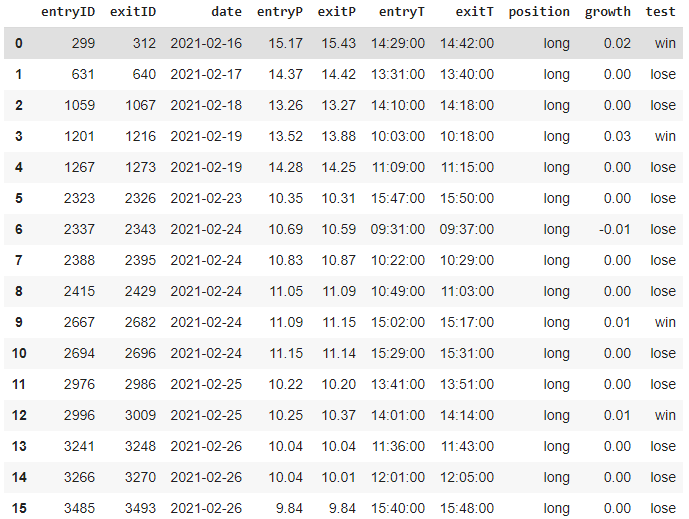

In [ ]:
def testLog(stock,testResult):
    # feed in stock and test result
    # used for plotting testing result
    df =  pd.DataFrame(stock.index, columns=['test'])
    df['test'] = 0
    df['time'] = 0
    for e,i in testResult.iterrows():
        if i['growth'] == 0:
            df.loc[i['entryID']:i['exitID'],'test'] = -0.002
            df.loc[i['entryID']:i['exitID'],'time'] = i.exitID - i.entryID
            df.loc[i['entryID']:i['exitID'],'position'] = i.position
            

        else:
            df.loc[i['entryID']:i['exitID'],'test'] = i['growth']
            df.loc[i['entryID']:i['exitID'],'time'] = i.exitID - i.entryID
            df.loc[i['entryID']:i['exitID'],'position'] = i.position
    

    return df

output of testLog should follow the format below, it use index as locator to plot trade in the plot

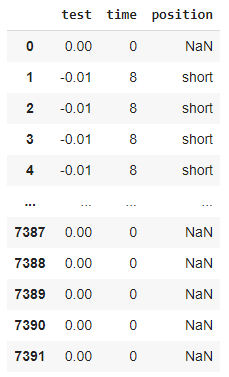

#### Plotting function

In [ ]:
def figLayout(stock):
    # configure the x axis tick, label and daily separate line in the layout
    group = stock.groupby('D')
    shape = []
    date = []
    lid = []
    for i in group.groups.keys():
        item = group.get_group(i).iloc[0]
        id = item.name
        dt = item['Datetime'].strftime('%m-%d')
        d = dict(type='line', xref='x',yref='paper',x0=id, y0=0, x1=id, y1=1, line = dict(color='grey', width=1,dash='dot'))
        shape.append(d)
        date.append(dt)
        lid.append(id)

    return {'shape':shape,'date':date,'tick':lid}

In [ ]:
def addTraceTrade(fig,df,r,c,name,color='steelblue', lg= False):
    # feed in testLog
    # use for plotting the test result on chart
    fig.add_trace(go.Scatter(x=df.index, y = df.test,
                             line_shape='hv',
                             fill='tozeroy',
                             hovertext=df['time'],
                             name=name,
                             legendgroup = name, 
                             showlegend = lg, 
                             line=dict(width=0.1, color=color))
    , row=r, col=c)


### MACD

#### MACD indicator

In [ ]:
# MACD indicator
def MACD(data,p,n=2):
    df= data.copy()
    df.sort_values('Datetime',ignore_index=True)
    exp1 = df[p].ewm(span=12*n, adjust=False).mean()
    exp2 = df[p].ewm(span=26*n, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9*n, adjust=False).mean()
    histogram = macd - signal
    df['macd'] = macd
    df['signal'] = signal
    df['macdhist'] = histogram
    return df

In [ ]:
#test code
#MACD(df,'Price')

#### MACD strategy

In [ ]:
def MACDstrategy(data,p,n= 5):
    stock = data.copy()
    df = pd.DataFrame(stock.index)
    df[['signal2','hist2']] = MACD(stock,'Price',n=n)[['signal','macdhist']]
    df[['signal1','hist1']] = MACD(stock,'Price',n=round(n/2))[['signal','macdhist']]

    df['buy'] = np.nan
    df.loc[(df['hist1'] > 0) & (df['hist2'] > 0), 'buy'] = 1
    df['buydiff'] = df['buy'].diff()

    df['sell'] = np.nan
    df.loc[(df['hist1'] < 0) & (df['hist2'] < 0), 'sell'] = -1
    df['selldiff'] = df['sell'].diff()

    # this locate the begining of every buy series and sell series in the dataframe
    buy = df.loc[(df['buy']==1) & (df['buydiff'].isnull())]
    sell = df.loc[(df['sell']==-1) & (df['selldiff'].isnull())]

    l = []
    for buy_index, i in buy.iterrows():
        try:
            next_sell_index = sell.loc[buy_index:].iloc[0].name
            buydf = df.loc[buy_index:next_sell_index]
            exit_index = moveUp(buydf.hist2)[1]
            l.append({'entry':buy_index,'exit':exit_index,'position':'long'})
        except:
            pass
    
    for sell_index,i in sell.iterrows():
        try:
            next_buy_index = buy.loc[sell_index:].iloc[0].name
            selldf = df.loc[sell_index:next_buy_index]
            exit_index = moveDown(selldf.hist2)[1]
            l.append({'entry':sell_index,'exit':exit_index,'position':'short'})
        except:
            pass
    return pd.DataFrame(l)

any strategy test should return the a table as below  
showing entryID, exitID and the position

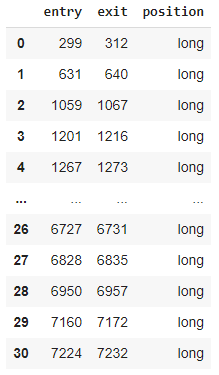

#### MACD test plot

In [ ]:
def addTraceMACD(fig,df,r,c):
    # adding MACD indicator to the plot
    fig.add_trace(go.Scatter(x=df.loc[df.macdhist>0].index, y = df.loc[df.macdhist>0].macdhist, fill= 'tozeroy',line=dict(width=0.1, color='green'),name='hist',legendgroup = 'hist',showlegend=False),row=r, col=c)
    fig.add_trace(go.Scatter(x=df.loc[df.macdhist<0].index, y = df.loc[df.macdhist<0].macdhist, fill= 'tozeroy',line=dict(width=0.1, color='red'),name='hist',legendgroup = 'hist',showlegend=False),row=r, col=c)
    fig.add_trace(go.Scatter(x=df.index, y=df.signal, name='signal',line_color='orange',legendgroup = 'signal',showlegend=False),row=r, col=c)
    fig.add_trace(go.Scatter(x=df.index, y=df.macd, name='macd',line_color='steelblue', legendgroup = 'macd',showlegend=False),row=r, col=c)

In [ ]:
def plotTestMACD(stock):
    # one stop plotting MACD testing with input stock dataframe
    df = stock.copy()
    layout = figLayout(df)

    fig = make_subplots(rows=7,cols=1,shared_xaxes=True,vertical_spacing=0.02)

    fig.add_trace(go.Scatter(x=df.index,y=df.Price, hovertext=df['T'],showlegend=False, name='price'),row=1,col=1)
    addTraceMACD(fig,MACD(df,'Price',n=2),r=2,c=1)
    addTraceMACD(fig,MACD(df,'Price',n=5),r=3,c=1)
    addTraceMACD(fig,MACD(df,'Price',n=10),r=4,c=1)
    addTraceMACD(fig,MACD(df,'Price',n=20),r=5,c=1)

   
    testResult = {}
    n2 = Testing(stock,MACDstrategy(stock,'Price',n=2))
    n5 = Testing(stock,MACDstrategy(stock,'Price',n=5))
    n10 = Testing(stock,MACDstrategy(stock,'Price',n=10))
    n20 = Testing(stock,MACDstrategy(stock,'Price',n=20))


    testResult['n2'] = n2.groupby('position')
    testResult['n5'] = n5.groupby('position')
    testResult['n10'] = n10.groupby('position')
    testResult['n20'] = n20.groupby('position')

    position = {'long':{}, 'short':{}}
    for p in position.keys():
        for t in testResult.keys():
            position[p][t] = testLog(stock,testResult[t].get_group(p))

    color = ['green','red','steelblue','orange']
    c = 0
    for i in position['long'].keys():
        addTraceTrade(fig,position['long'][i],r=6,c=1,name=i,lg=False,color=color[c])
        c+=1
    c =0 
    for i in position['short'].keys():
        addTraceTrade(fig,position['short'][i],r=7,c=1,name=i,lg=True, color=color[c])
        c+= 1


    fig.update_layout(height = 900,
                      hovermode = 'x',
                      shapes = layout['shape'],
                      xaxis7 = dict(tickmode='array', tickvals=layout['tick'], ticktext=layout['date']))
    fig.show()


    def MACDreport(ds):
        fig = make_subplots(rows=3 , cols = 4, shared_yaxes=True, shared_xaxes=True, vertical_spacing=0.02, horizontal_spacing=0.02)
        for e in range(len(ds)):
            ptn = ds[e].groupby(['position','test','growth']).count()
            for i in [['long',1],['short',2]]:
                for c in [['win','green'],['lose','red'],['even','grey']]:
                    fig.add_trace(go.Bar(x=ptn.loc[(i[0],c[0])].index, y = ptn.loc[(i[0],c[0])].exitP, marker_color=c[1], name=c[0], legendgroup=c[0],showlegend=False),row=i[1],col=e+1)
            tn = ds[e].groupby(['test','growth']).count()
            for c in [['win','green'],['lose','red'],['even','grey']]:
                if e == 0:
                    fig.add_trace(go.Bar(x=tn.loc[c[0]].index, y = tn.loc[c[0]].exitP, marker_color=c[1], name=c[0], legendgroup=c[0],showlegend=True),row=3,col=e+1)
                else:
                    fig.add_trace(go.Bar(x=tn.loc[c[0]].index, y = tn.loc[c[0]].exitP, marker_color=c[1], name=c[0], legendgroup=c[0],showlegend=False),row=3,col=e+1)
        fig1 = make_subplots(rows=3 , cols = 4, shared_yaxes=True, shared_xaxes=True, vertical_spacing=0.02, horizontal_spacing=0.02)
        for e in range(len(ds)):
            ptn = ds[e].groupby(['position','test']).sum()
            for i in [['long',1],['short',2]]:
                #for c in [['win','green'],['lose','red'],['even','grey']]:
                fig1.add_trace(go.Bar(x=ptn.loc[(i[0])].index, y = ptn.loc[(i[0])].growth,showlegend=False, marker_color=['grey','red','green']),row=i[1],col=e+1)
            tn = ds[e].groupby('test').sum()
            fig1.add_trace(go.Bar(x=tn.index, y = tn.growth, showlegend=False,marker_color=['grey','red','green']),row=3,col=e+1)  
        fig.update_layout(height = 500, hovermode = 'x')
        fig1.update_layout(height = 500, hovermode = 'x')
        fig.show()
        fig1.show()

    MACDreport([n2,n5,n10,n20])

MACD plotting use all the functions related to MACD strategy to plot out the indicator and the test result (4x for different scale period)  
**When running on a slice of data, that slice need to be reset index - stock input data need to have ordered index**

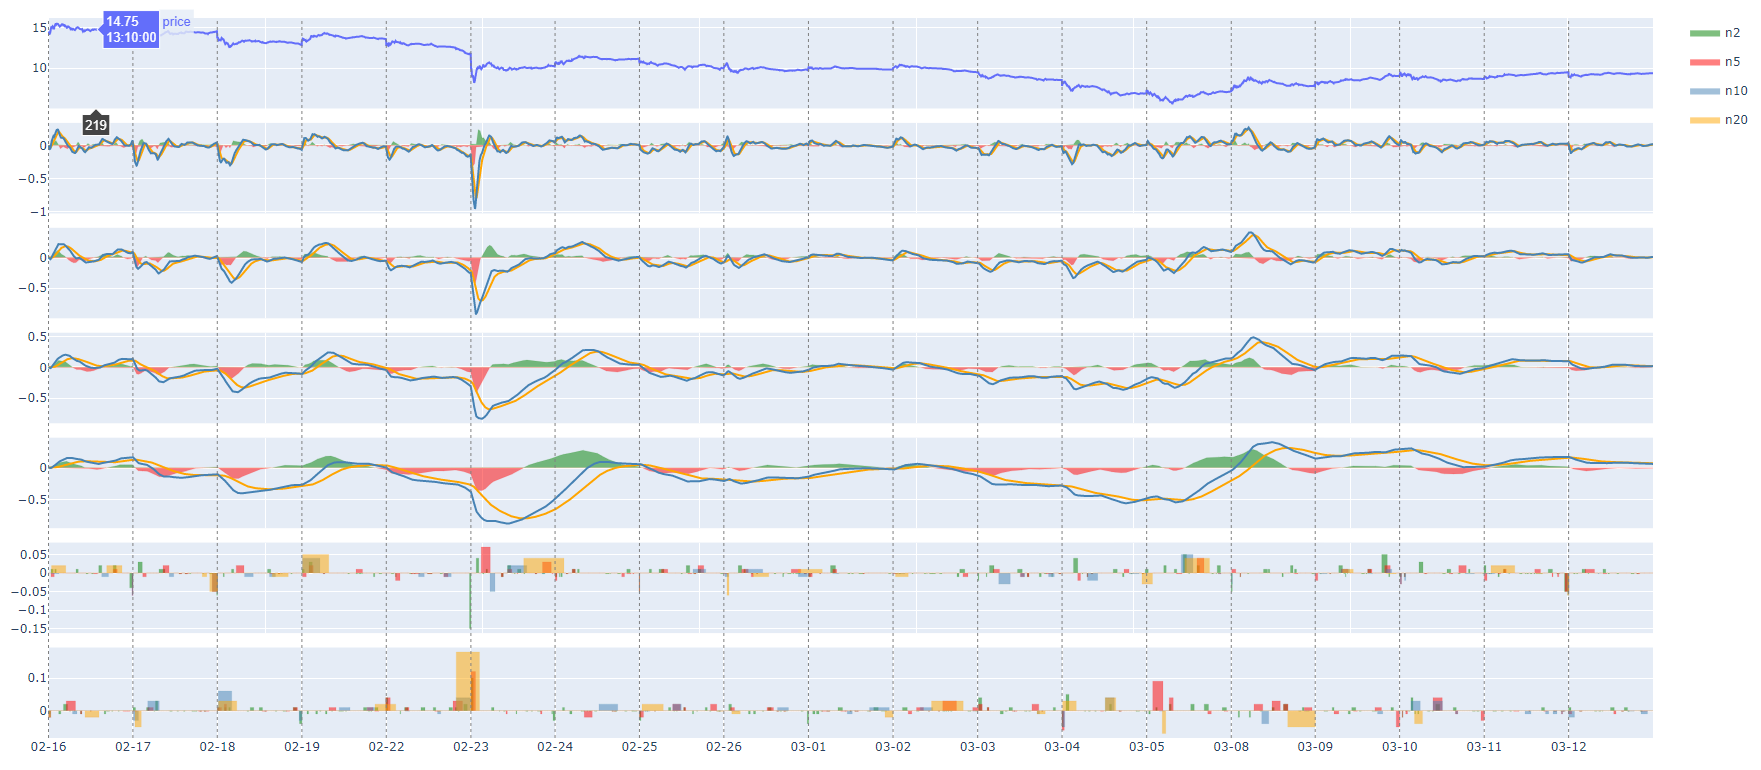

### VWAP

In [ ]:
def VWAP(data, p):
# run VWAP on the section of data to be examined
# as it is cummulative, it will be hug toward the end
    df= data.copy()
    df.sort_values('Datetime',ignore_index=True,inplace=True)
    VWAP = (df[p]*df.Volume).cumsum() / df.Volume.cumsum()
    df['vwap'] = VWAP
    return df

In [ ]:
#test code
#VWAP(df,'Price')

### Ichimoky Kinko Hyo

In [ ]:
def ICMK(data):
    df = data.copy()
    df.sort_values('Datetime',ignore_index=True,inplace=True)
    conversion = (df.High.rolling(9).max() + df.Low.rolling(9).min())/2
    base = (df.High.rolling(26).max() + df.Low.rolling(26).min())/2
    leadA = (conversion + base)/2
    leadB = (df.High.rolling(52).max() + df.Low.rolling(52).min())/2
    lag = df.Close.shift(-26)
    df['ICMK_conversion'] = conversion
    df['ICMK_base'] = base
    df['ICMK_leadA'] = leadA
    df['ICMK_leadB'] = leadB
    df['ICMK_lag'] = lag
    return df


In [ ]:
#test code
#ICMK(df,'Price')